In [ ]:
!git clone https://github.com/neurodata/SPORF.git

%cd /content/SPORF/Python

!apt-get update
!apt-get install build-essential cmake python3-dev libomp-dev libeigen3-dev   # Ubuntu/Debian


!python setup.py clean --all

!pip install -e .

Cloning into 'SPORF'...
remote: Enumerating objects: 9102, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 9102 (delta 47), reused 93 (delta 32), pack-reused 8974 (from 1)
Receiving objects: 100% (9102/9102), 111.07 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (5104/5104), done.
Updating files: 100% (2125/2125), done.
/content/SPORF/Python
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InReleas

In [ ]:
# List of imports
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# CSE176 — Part 3: SPORF on MAGIC Gamma Telescope — Experiment & Plot Checklist

This file is a single ordered checklist you can copy into your Colab notebook as an outline. It is arranged to:
1. produce reproducible data and artifacts,  
2. run strong baseline comparisons,  
3. do thorough SPORF-specific experiments and tuning, and  
4. produce all diagnostic plots/tables needed for an excellent report.

Recommended constants (use throughout): random_seeds = [0,1,2,3,4], n_splits = 5 (stratified CV), repeats = 3. Save environment info (pip freeze) and the SPORF git commit hash.

---

## 1. Setup & reproducibility
- Install required libs and clone SPORF staging branch.
  - scikit-learn, xgboost/lightgbm, shap, umap-learn, seaborn, kaggle, pandas, matplotlib.
- Authenticate Kaggle (kaggle.json) and download the MAGIC Gamma Telescope dataset; save a copy to Google Drive.
- Set global constants and seeds.
- Save environment info (pip freeze) and notebook metadata.

Outputs to save: requirements.txt (pip freeze), SPORF git commit SHA, list of seeds used.

---

## 2. Raw-data checks (EDA - first pass)
- Print dataset shape: #samples, #features, class labels.
- Class distribution bar chart (counts and percentages).
- Missing-values table / heatmap (if none, state explicitly).
- Per-feature summary table: mean, std, min, max, skewness, kurtosis.
- List top outliers per feature.

Plots/tables: dataset_summary.csv, class_distribution.png, feature_summary.csv.

---

## 3. Univariate & bivariate feature exploration
- For each numeric feature: histogram + KDE, separated by class.
- Boxplots / violin plots per feature by class.
- Pairwise scatterplots for top 4–6 features correlated with label.
- Correlation matrix heatmap (Pearson). Annotate correlations > 0.8.

Plots: histograms/, boxplots/, pairplot.png, corr_heatmap.png.

---

## 4. Dimensionality reduction visualizations
- PCA:
  - Scree plot (explained variance by component).
  - PCA scatter (PC1 vs PC2) colored by class with 95% ellipses.
- t-SNE and/or UMAP 2D scatter colored by class.
- (Optional) PCA decision-boundary demo for a simple classifier.

Plots: pca_scree.png, pca_scatter.png, umap_tsne.png.

---

## 5. Preprocessing decisions log
- Show effect of scaling (before/after plots) if using non-tree baselines.
- Save and use one consistent stratified split (recommended 70% train, 15% val, 15% test) or use CV + holdout test.
- Report class stratification percentages per split.
- Save split indices to disk.

Artifacts: split_indices.pkl, preprocessing_pipeline.pkl.

---

## 6. Baseline models (sanity & benchmark)
Train and evaluate on same splits/CV:
- Logistic Regression (L2)
- SVM (linear & RBF)
- RandomForest (sklearn)
- XGBoost or LightGBM

For each:
- Save model and predictions.
- Metrics: Accuracy, Balanced Accuracy, Precision, Recall, F1, ROC AUC, PR AUC.

Plots/tables:
- metrics_table_baselines.csv
- ROC curves overlay (validation)
- PR curves overlay (validation)
- Bar chart comparing ROC AUC & F1 with error bars across seeds/CV folds
- Confusion matrix heatmap for best baseline (test)

---

## 7. SPORF: initial run (default hyperparameters)
- Build/import SPORF API and run with default settings on train set.
- Evaluate on val/test and add SPORF to baseline comparison overlays.
- Save SPORF model artifact.

Plots/tables: add SPORF lines to ROC/PR overlays, metrics_table.csv update.

---

## 8. SPORF hyperparameter sweep (systematic tuning)
- Identify SPORF hyperparameters to tune (examples):
  - n_estimators: [50,100,200,500]
  - max_depth / max_leaf_nodes (if available)
  - projection dimension and sparsity (k, density)
  - feature subsampling fraction (mtry)
  - sample fraction, min_samples_leaf
- Use stratified CV (5-fold) with repeated seeds; primary metric: ROC AUC, secondary: PR AUC / F1.
- Save CV results as CSV for all runs.

Plots:
- Validation curves (metric vs hyperparameter) for each hyperparameter.
- 2D heatmaps for two-hyperparam interactions (e.g., n_estimators vs projection_sparsity).
- Boxplots showing CV distribution for top hyperparameter settings.

Artifacts: sporf_hyperparam_results.csv, hyperparam_plots/.

---

## 9. Final SPORF training & test evaluation
- Retrain SPORF on train+validation using best hyperparameters (found above).
- Evaluate once on held-out test set.

Produce:
- Final ROC curve (test) and AUC (with 95% CI if bootstrapped).
- Final PR curve and PR AUC (test).
- Confusion matrix (raw + normalized).
- Table of final metrics (Accuracy, Balanced Accuracy, Precision, Recall, F1, ROC AUC, PR AUC, Specificity, NPV).
- Calibration plot (reliability diagram) and Brier score. Optionally show calibrated probabilities (Platt/isotonic).

Artifacts: final_model.pkl, test_predictions.csv, final_metrics.csv.

---

## 10. Model comparison & statistical significance
- Perform paired tests comparing SPORF vs best baseline:
  - McNemar test on test predictions.
  - Paired t-test or Wilcoxon signed-rank on CV metric distributions (e.g., ROC AUC across folds).
- Plot bar chart of mean metric ± 95% CI and annotate p-values.

Outputs: significance_tests.csv, comparison_plot.png.

---

## 11. Learning curves & sample efficiency
- Learning curve: training vs validation score (ROC AUC or F1) vs training set size: [10%,25%,50%,75%,100%].
- Runtime vs training set size for SPORF and a strong baseline (RandomForest/XGBoost).
- Plot metric vs n_estimators / model complexity.

Plots: learning_curve.png, runtime_curve.png.

---

## 12. Model complexity & runtime profiling
- Measure and compare:
  - Training time and inference time per sample (SPORF vs baselines).
  - Memory usage if possible (or approximate).
  - Distribution of tree depths and node counts across trees.
  - Average number of features used per split / average nonzero projection weights.

Plots/tables: runtime_table.csv, tree_stats.png, projection_usage.png.

---

## 13. Interpretability & feature importance
- Compute feature importance by:
  - Mean decrease in impurity (if provided).
  - Permutation importance (with repeats) — ranked bar chart.
  - SHAP summary plot (Tree SHAP if supported; otherwise KernelSHAP on a subset).
- Partial dependence plots (PDPs) for top 3 features and 2D PDP for top feature pairs.
- SHAP dependence plots for top features.

SPORF-specific interpretability:
- Aggregate projection coefficients across trees and show heatmap of feature contributions.
- Distribution plots of projection weights per feature (boxplots/violins).
- Print one or two example tree decision paths (show projection weights & thresholds).

Artifacts: feature_importance.csv, shap_summary.png, pdep_plots/.

---

## 14. Threshold decision & business metrics
- Precision-Recall vs threshold plot and recommend operating point(s) (max F1, Youden index, or cost-based).
- Confusion-matrix-based cost curve / expected cost vs threshold using sample cost scenarios.
- Lift chart / cumulative gains plot (ranking performance).

Plots: threshold_analysis.png, lift_chart.png.

---

## 15. Robustness & sensitivity analyses
- Random-seed sensitivity: boxplots of metrics across seeds.
- Subsample stability: train on random 80% subsamples (multiple repeats) and show variance in metrics and feature importances.
- Noisy features test: add Gaussian noise to top features (various SNRs) and plot metric degradation.
- Class-imbalance sensitivity: downsample/upsample experiments and effect on metrics.

Outputs: robustness_results.csv, sensitivity_plots/.

---

## 16. Ablation studies
- Remove top-k features (k=1,2,3) and retrain SPORF; plot metric vs k.
- Compare SPORF vs axis-aligned random forest of similar complexity: table + bar plots (metrics and tree complexity).

Artifacts: ablation_results.csv, ablation_plots.png.

---

## 17. Final diagnostic & recommended model artifact outputs
- Save final model and preprocessing pipeline (pickle or joblib).
- Save CSV of test set with: sample_id, true_label, predicted_label, predicted_proba, features.
- Create a one-page summary figure (panel) for the report: dataset stats, ROC+PR, feature importance, calibration plot.

Artifacts: final_artifacts.zip, test_results.csv, summary_panel.png.

---

## 18. Report figures & appendix items to include
- Export all plots as high-resolution PNGs and reference them in the report.
- Save tables as CSV/markdown.
- Reproducibility appendix: environment (pip freeze), exact SPORF commit, seeds, and instructions for re-running the notebook.

---

## 19. Final checklist before submission
- Every figure has caption, axis labels, units, and legend.
- Every experiment documents: data split, CV details, #repeats, seeds.
- Short interpretation paragraph for each figure: what it shows and why it matters.
- Ensure the notebook runs from top-to-bottom in a clean Colab environment.

---

## Practical Colab notebook cell order (suggested)
1. Setup (installs, git clone SPORF@staging, imports)
2. Load dataset & EDA summary plots
3. Preprocessing & save split indices
4. Baseline training & evaluation + plots
5. SPORF default run
6. SPORF hyperparameter tuning (log/save CV results)
7. Final SPORF training & test evaluation
8. Interpretability (SHAP, PDP) and projection analyses
9. Robustness, ablations, learning curves
10. Save artifacts, pip freeze, git commit SHA, export figures/tables

---

If you want, I can now:
- Generate a ready-to-run Colab notebook skeleton with the exact Python code cells implementing this plan (include installs, data download via Kaggle API, baseline training loops, SPORF training calls, plotting code, and file saving).  
- Indicate whether to include a full automated hyperparameter search (GridSearchCV or randomized search) or a minimal manual tuning scaffold.

Which option do you want for the Colab skeleton: full automated search or minimal tuning scaffold?
```

In [ ]:
# 1 Download the Magic-Gamma-Telescope-Dataset
path = kagglehub.dataset_download("abhinand05/magic-gamma-telescope-dataset")
df = pd.read_csv(path + '/telescope_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)

# In order to use the dataset I'll chage h -> 0 and g -> 1
df['class'] = df['class'].map({'g': 0, 'h': 1})

COLUMNS = df.columns
FEATURES = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym','fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
LABEL = ['class']

Using Colab cache for faster access to the 'magic-gamma-telescope-dataset' dataset.


 Database shape: (13020, 11)
 Class labels: [0 1]


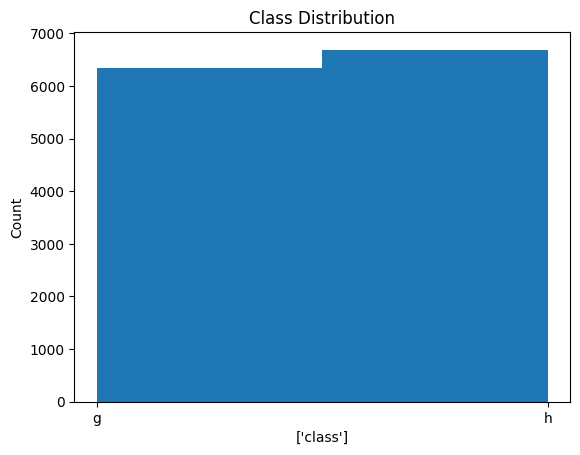


Histograms for Numerical Features:


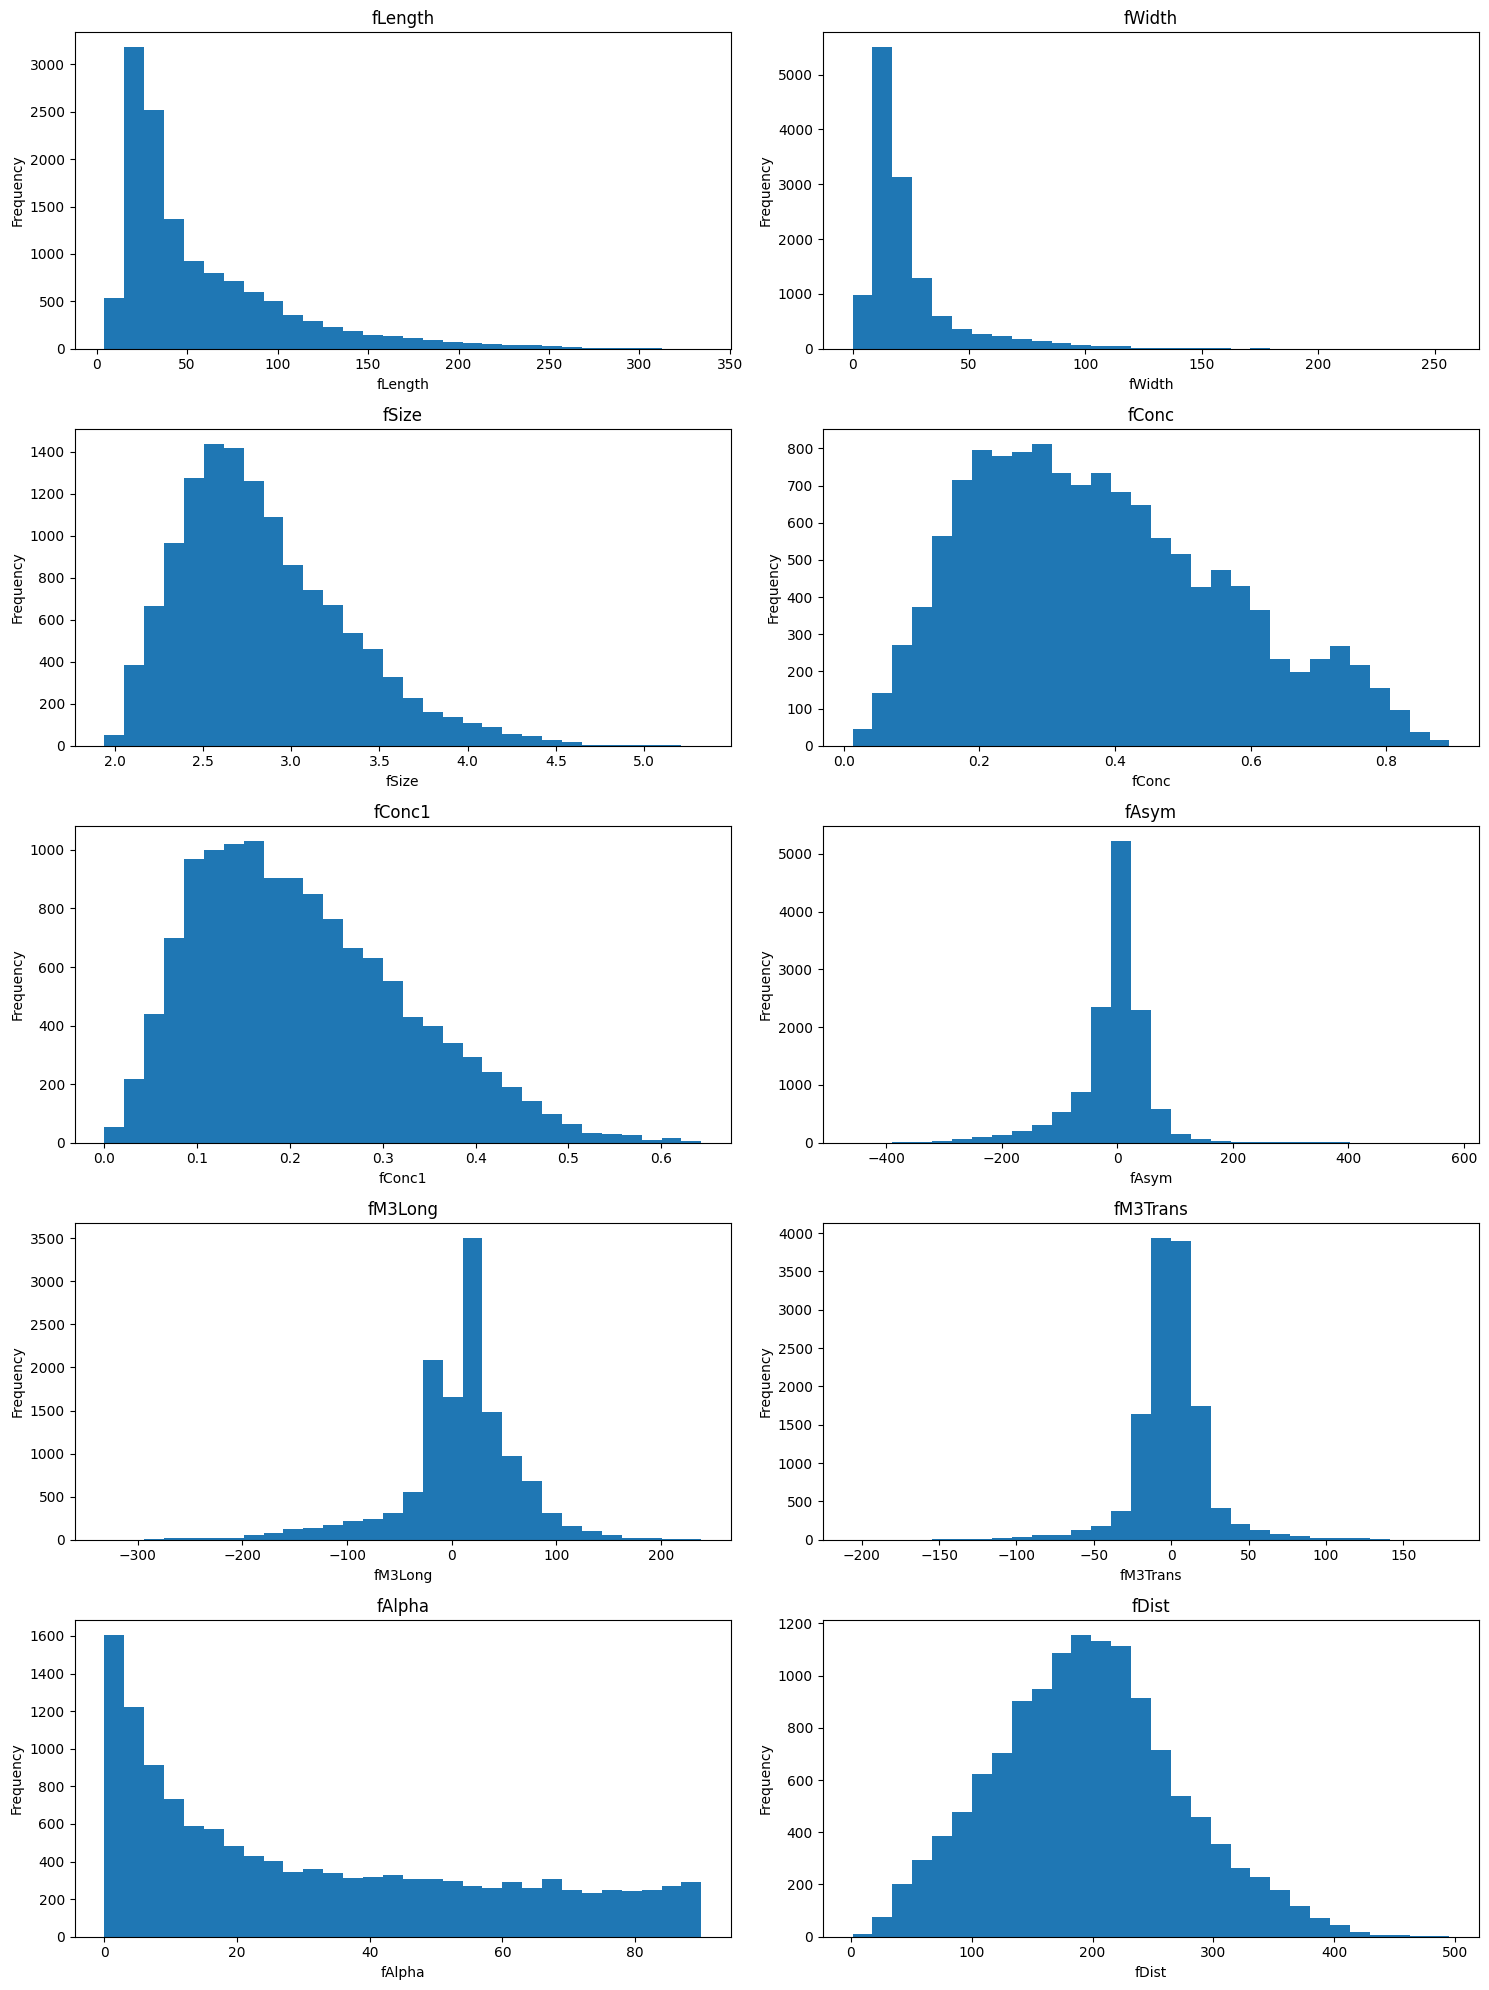


Missing Values:
No missing values found.

Per-feature Summary Table:
fLength      57.800526
fWidth       23.812060
fSize         2.845051
fConc         0.378835
fConc1        0.214442
fAsym        -7.397471
fM3Long       7.417175
fM3Trans      0.275682
fAlpha       31.712913
fDist       195.458249
class         0.513671
dtype: float64


In [ ]:
# 2 Raw-data checks
# Print dataset shape: #samples, #features, class labels.
print(f" Database shape: {df.shape}")
print(f" Class labels: {df['class'].unique()}")

# Class distribution bar chart (counts and percentages).
plt.hist(df['class'], bins=2)
plt.xlabel(LABEL)
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['g', 'h'])
plt.show()

# Then, loop through numerical columns for histograms
print("\nHistograms for Numerical Features:")
# Create a 5x2 grid for the histograms
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten() # Flatten the 5x2 array of axes for easy iteration

for i, col in enumerate(FEATURES):
    axes[i].hist(df[col], bins=30)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# Missing-values table / heatmap (if none, state explicitly).
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if missing_values.empty:
    print("No missing values found.")
else:
    print(missing_values)

# Per-feature summary table: mean, std, min, max, skewness, kurtosis.
print("\nPer-feature Summary Table:")
summary_stats = df.mean()
print(summary_stats)

In [ ]:
# Univariate & bivariate feature exploration
# For each numeric feature: histogram + KDE, separated by class (overlay or small multiples).
# Boxplots or violin plots per feature by class (highlights distribution differences).
# Pairwise scatterplots for top 4–6 features most correlated with label (or use seaborn.pairplot on a curated subset).
# Correlation matrix heatmap (Pearson) for features; annotate large correlations > 0.8.
# Feature vs class violin/hist for the most discriminative features.

In [ ]:
# Split in X and y
X = df[FEATURES]  # Features
y = df['class']  # Labels

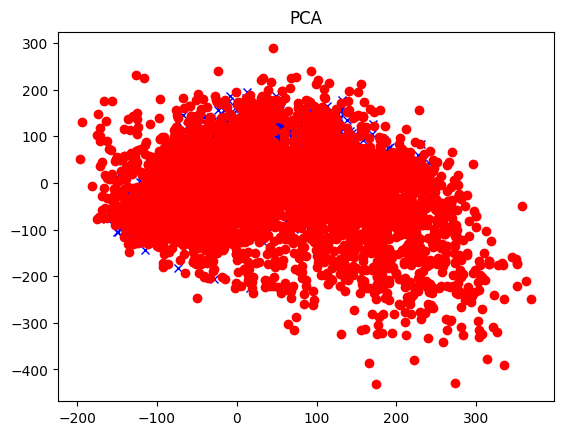

In [ ]:
# LDA to show the data for a binary classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# PCA to show the data for a binary classifier
pca=PCA(n_components=2)
projections=pca.fit_transform(X,y)
plt.figure()
for c,m,i in [('b','x', 0),('r','o',1)]:
  indices=np.where(y==i)
  xs=projections[indices,0]
  ys=projections[indices,1]
  plt.plot(xs,ys,c=c,marker=m, label=f'Class {i}')
plt.title('PCA')
plt.show()

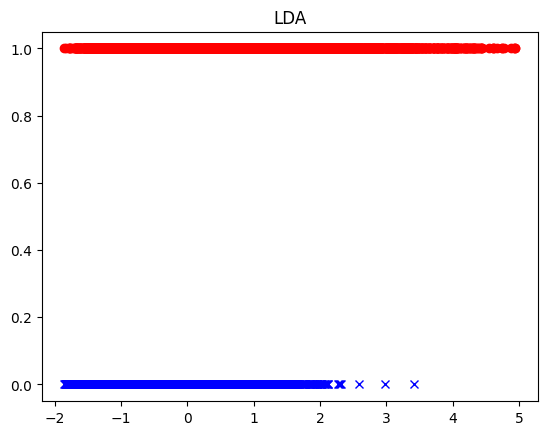

In [ ]:
# LDA
lda=LDA(n_components=1)
projections=lda.fit_transform(X,y)
W=lda.coef_
b=lda.intercept_
plt.figure()
for c,m,i in [('b','x', 0),('r','o',1)]:
  indices=np.where(y==i)
  xs=projections[indices,0]
  plt.plot(xs, np.zeros_like(xs)+i,c=c,marker=m, label=f'Class {i}')
plt.title('LDA')
plt.show()

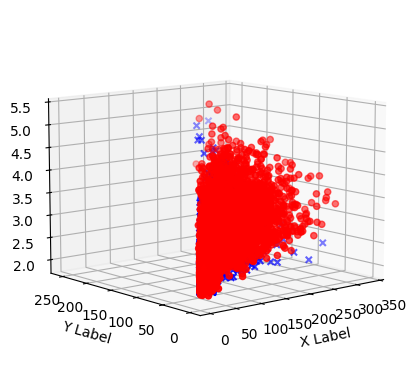

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c,m,i in [('b','x',0),('r','o',1)]:
  indices=np.where(y==i)
  # Correctly index the DataFrame using iloc and the array of indices
  xs=X.iloc[indices[0],0] # First feature
  ys=X.iloc[indices[0],1] # Second feature
  zs=X.iloc[indices[0],2] # Third feature
  ax.scatter(xs,ys,zs,c=c,marker=m)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

# Rotate the graph
ax.view_init(elev=10, azim=230) # Example rotation: 20 degrees elevation, 45 degrees azimuth

plt.show()

In [ ]:
# Split the data in train and test
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5
)

print(len(X_train)/len(X))
print(len(X_test)/len(X))
print(len(X_val)/len(X))


0.7
0.15
0.15


In [ ]:
# Logistic Regression (with L2)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
import time

start = time.time()
ovo_clf = OneVsOneClassifier(LogisticRegression(max_iter=1000)).fit(X_train, y_train)
end = time.time()
y_pred_linear = ovo_clf.predict(X_test)
print(f"Accuracy linear classifier: {accuracy_score(y_test, y_pred_linear)}")
print(f"Training time linear classifier: {(end - start):.5} seconds")


# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
start = time.time()
rf_clf = RandomForestClassifier().fit(X_train, y_train)
end = time.time()
y_pred_RF = rf_clf.predict(X_test)
print(f"Accuracy random forest classifier: {accuracy_score(y_test, y_pred_RF)}")
print(f"Training time random forest classifier: {(end - start):.5} seconds")

# Kernel SVM
from sklearn.svm import SVC
start = time.time()
svm_clf = SVC(kernel='rbf').fit(X_train, y_train)
end = time.time()
y_pred_SVM = svm_clf.predict(X_test)
print(f"Accuracy SVM classifier: {accuracy_score(y_test, y_pred_SVM)}")
print(f"Training time SVM classifier: {(end - start):.5} seconds")

# SFORF
from rerf.rerfClassifier import rerfClassifier
start = time.time()
sporf_clf = rerfClassifier(n_estimators=100).fit(X_train, y_train)
end = time.time()
y_pred_SPORF = sporf_clf.predict(X_test.to_numpy())
print(f"Accuracy SFORF classifier: {accuracy_score(y_test, y_pred_SPORF)}")
print(f"Training time SFORF classifier: {(end - start):.5} seconds")

Accuracy linear classifier: 0.7924991237294077
Training time linear classifier: 1.5388 seconds
Accuracy random forest classifier: 0.889589905362776
Training time random forest classifier: 12.693 seconds
Accuracy SVM classifier: 0.827900455660708
Training time SVM classifier: 5.1541 seconds
Accuracy SFORF classifier: 0.8818787241500176
Training time SFORF classifier: 4.6646 seconds


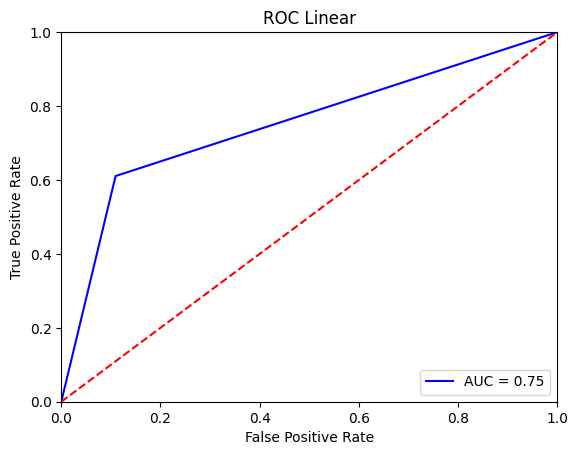

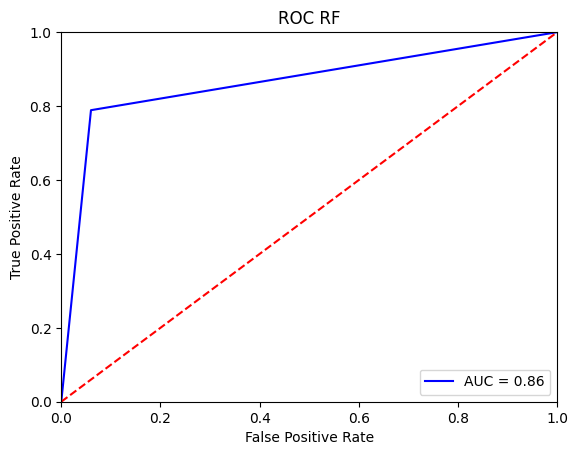

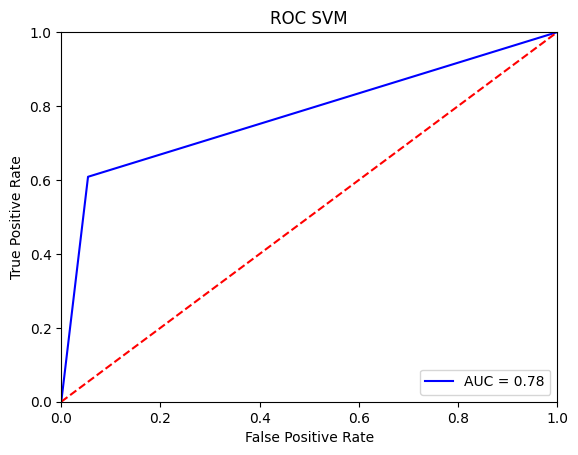

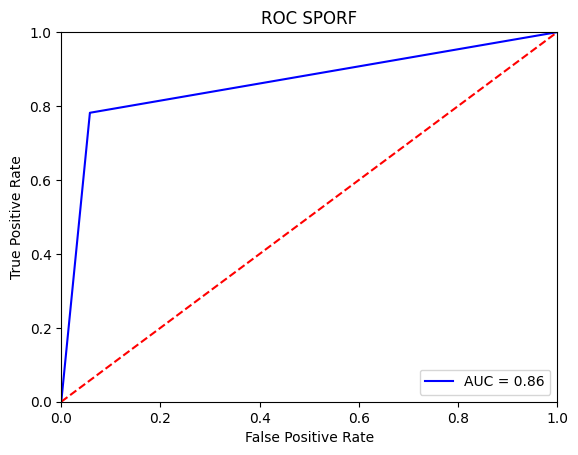

In [ ]:
# ROC curves (multi-model overlay) on the validation set (one line per model) with AUC in legend.
def plot_roc_curve(y_test, y_pred, title):
  from sklearn.metrics import roc_curve, auc
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.title(f'ROC {title}')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# Linear
plot_roc_curve(y_test, y_pred_linear, 'Linear')

# RF
plot_roc_curve(y_test, y_pred_RF, 'RF')

# SVM
plot_roc_curve(y_test, y_pred_SVM, 'SVM')

# SPORF
plot_roc_curve(y_test, y_pred_SPORF, 'SPORF')


In [ ]:
# SPORF hyperparameter sweep (systematic tuning)
from sklearn.model_selection import
# projection_matrix
cv_results =
print(cv_results)


# n_estimators
# max_features
# min_samples_split


NameError: name 'sporf_clf' is not defined